In [1]:
import os
import csv
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation
from scipy.integrate import trapz

# Select Normalization for Jerk Calculation
Set variable to true in order to use the global normalized jerk, otherwise the values are locally normalized <br>
This variable is used in all relevant scripts to have the same jerk calculation

In [2]:
global_jerk = False

# do not change!
jerk_normalization = ''
if global_jerk: jerk_normalization = '_global'
%store jerk_normalization

Stored 'jerk_normalization' (str)


# Import Data

In [3]:
data_directory = "./IMU_Recordings"
file_names = ["01IMU.csv", "02IMU.csv", "04IMU.csv", "05IMU.csv", "06IMU.csv", "07IMU.csv", "08IMU.csv", "09IMU.csv", "10IMU.csv", "11IMU.csv", "12IMU.csv", "13IMU.csv", "14IMU.csv", "15IMU.csv", "17IMU.csv", "18IMU.csv"]
person_names = ["p1", "p2", "p3", "p4", "p5", "p6", "p7", "p8", "p9", "p10", "p11", "p12", "p13", "p14", "p15", "p16"]

# Initialize dictionaries to store DataArrays for each person
acc_dict = {}
quat_dict = {}
time_dict = {}

In [4]:
# Extract data from csv and save to dictionnairies
for file_name, person_name in zip(file_names, person_names):
    file_path = os.path.join(data_directory, file_name)
    data = pd.read_csv(file_path)

    # Extract acceleration, quaternion, and time data from the dataset
    acc = np.array([data['Acc_X'], data['Acc_Y'], data['Acc_Z']])
    q = np.array([data['Quat_X'], data['Quat_Y'], data['Quat_Z'], data['Quat_W']])
    # Create a time array starting from 0 increasing by 1
    time = np.arange(len(data['SampleTimeFine']))

    # Reshape the quaternion array to have each quaternion as a row
    reshaped_q = np.transpose(q)

    # Convert to DataArrays
    acc_x = xr.DataArray(acc[0], dims=('time',), coords={'time': time})
    acc_y = xr.DataArray(acc[1], dims=('time',), coords={'time': time})
    acc_z = xr.DataArray(acc[2], dims=('time',), coords={'time': time})
    quat_x = xr.DataArray(q[0], dims=('time',), coords={'time': time})
    quat_y = xr.DataArray(q[1], dims=('time',), coords={'time': time})
    quat_z = xr.DataArray(q[2], dims=('time',), coords={'time': time})
    quat_w = xr.DataArray(q[3], dims=('time',), coords={'time': time})

    # Store DataArrays in dictionnaries
    acc_dict[person_name] = xr.Dataset({'acc_x': acc_x, 'acc_y': acc_y, 'acc_z': acc_z})
    quat_dict[person_name] = reshaped_q
    time_dict[person_name] = time

In [5]:
# Add gender information for each person
acc_dict['p1']['gender'] = 'male'
acc_dict['p2']['gender'] = 'female'
acc_dict['p3']['gender'] = 'female'
acc_dict['p4']['gender'] = 'male'
acc_dict['p5']['gender'] = 'female'
acc_dict['p6']['gender'] = 'female'
acc_dict['p7']['gender'] = 'female'
acc_dict['p8']['gender'] = 'male'
acc_dict['p9']['gender'] = 'male'
acc_dict['p10']['gender'] = 'male'
acc_dict['p11']['gender'] = 'male'
acc_dict['p12']['gender'] = 'female'
acc_dict['p13']['gender'] = 'female'
acc_dict['p14']['gender'] = 'female'
acc_dict['p15']['gender'] = 'male'
acc_dict['p16']['gender'] = 'male'

# Gravity Compensation
First reshape acceleration data to the following format: p1([acc_x1, acc_y1, acc_z1], [acc_x2, acc_y2, acc_z2], ...) instead of p1([acc_x], [acc_y], [acc_z])

In [6]:
reshaped_acc_dict = {}
for person_name, acc_dataset in acc_dict.items():
    reshaped_acc = np.array([acc_dataset['acc_x'], acc_dataset['acc_y'], acc_dataset['acc_z']])
    reshaped_acc = np.transpose(reshaped_acc)
    reshaped_acc_dict[person_name] = reshaped_acc

Convert the acceleration data from the IMU sensor data frame to global data frame using the quaternions. First a rotation matrix is computed using the jerks and then multiplied with the IMU sensor data frame. To compensate gravity, g is subtracted in the transformed z-axis.

In [7]:
# Gravitation as array [x, y, z]
g = np.array([0, 0, 9.81])

for person_name, quat_data in quat_dict.items():
    acc_data = reshaped_acc_dict[person_name]
    num_samples = quat_data.shape[0]
    
    # Init
    acc_global = np.zeros((num_samples, 3))
    
    # Iterate over each sample
    for i in range(num_samples):
        # Compute Rotation Matrix
        r = Rotation.from_quat(quat_data[i]).as_matrix()
        # Rotation and gravity compensation by subtracting g
        acc_global[i] = np.dot(r, acc_data[i]) - g
    
    time = time_dict[person_name]
    
    acc_x_gravity_compensated = xr.DataArray(acc_global[:, 0], dims=('time',), coords={'time': time})
    acc_y_gravity_compensated = xr.DataArray(acc_global[:, 1], dims=('time',), coords={'time': time})
    acc_z_gravity_compensated = xr.DataArray(acc_global[:, 2], dims=('time',), coords={'time': time})
    
    # Add global acceleration DataArray objects to acc_dict
    acc_dict[person_name]['acc_x_gravity_compensated'] = acc_x_gravity_compensated
    acc_dict[person_name]['acc_y_gravity_compensated'] = acc_y_gravity_compensated
    acc_dict[person_name]['acc_z_gravity_compensated'] = acc_z_gravity_compensated

# Calculate Jerk as Derivative
Jerk is the derivative of the acceleration, which was measured by the IMU. Therefore the derivative of the measured values is calculated and saved into the dictionnairy
## Jerk in all axis
Computation of the jerk in all axec (x, y, z)

In [8]:
# Calculate the derivative for acc_x, acc_y, and acc_z for each person
for person_name in acc_dict:
    acc_dataset = acc_dict[person_name]

    acc_dataset['acc_x_derivative'] = acc_dataset['acc_x_gravity_compensated'].differentiate('time')
    acc_dataset['acc_y_derivative'] = acc_dataset['acc_y_gravity_compensated'].differentiate('time')
    acc_dataset['acc_z_derivative'] = acc_dataset['acc_z_gravity_compensated'].differentiate('time')

## Jerk as magnitude of 3D vector
Calculation of the acceleration as magnitude of the 3D vector and then computing the jerk as derivative of the acceleration vector

In [9]:
for person_name, acc_data in acc_dict.items():
    # Extract gravity compensated acceleration data for the current person
    acc_x = acc_data['acc_x_gravity_compensated']
    acc_y = acc_data['acc_y_gravity_compensated']
    acc_z = acc_data['acc_z_gravity_compensated']
    
    # Calculate the magnitude of the acceleration vector
    magnitude = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)
    magnitude_xz = np.sqrt(acc_x**2 + acc_z ** 2)
    
    # Create a DataArray for the jerk vector
    acc_vector = xr.DataArray(magnitude, dims=('time'), coords={'time': acc_x.time})
    acc_xz = xr.DataArray(magnitude_xz, dims=('time'), coords={'time': acc_x.time})
    
    # Differentiate to get the jerk
    acc_vector_derivative = acc_vector.differentiate('time')
    acc_xz_derivative = acc_xz.differentiate('time')
    
    # Assign the jerk vector to the acc_dict
    acc_dict[person_name]['acc_vector_derivative'] = acc_vector_derivative
    acc_dict[person_name]['acc_xz_derivative'] = acc_xz_derivative

# Normalization
## Local Maximum
Normalization of the jerk in all 3 axis and the vector using local maximum value. Therefore the maximum value of each person is used to normalize the data

In [10]:
for person_name in acc_dict:
    acc_dataset = acc_dict[person_name]
    acc_x_derivative = acc_dataset['acc_x_derivative']
    acc_y_derivative = acc_dataset['acc_y_derivative']
    acc_z_derivative = acc_dataset['acc_z_derivative']
    acc_vector_derivative = acc_dataset['acc_vector_derivative']
    acc_xz_derivative = acc_dataset['acc_xz_derivative']
    
    max_acc_x_derivative = np.max(np.abs(acc_x_derivative))
    max_acc_y_derivative = np.max(np.abs(acc_y_derivative))
    max_acc_z_derivative = np.max(np.abs(acc_z_derivative))
    max_acc_vector_derivative = np.max(np.abs(acc_vector_derivative))
    max_acc_xz_derivative = np.max(np.abs(acc_xz_derivative))
    
    acc_x_derivative_normalized = acc_x_derivative / max_acc_x_derivative
    acc_y_derivative_normalized = acc_y_derivative / max_acc_y_derivative
    acc_z_derivative_normalized = acc_z_derivative / max_acc_z_derivative
    acc_vector_derivative_normalized = acc_vector_derivative / max_acc_vector_derivative
    acc_xz_derivative_normalized = acc_xz_derivative / max_acc_xz_derivative
    
    acc_dataset['acc_x_derivative_normalized'] = acc_x_derivative_normalized
    acc_dataset['acc_y_derivative_normalized'] = acc_y_derivative_normalized
    acc_dataset['acc_z_derivative_normalized'] = acc_z_derivative_normalized
    acc_dataset['acc_vector_derivative_normalized'] = acc_vector_derivative_normalized
    acc_dataset['acc_xz_derivative_normalized'] = acc_xz_derivative_normalized

## Normalization with global maximum 

Hereby the global maximum of all persons is used to normalize each dataset. First compute each persons maximum of absolute values and then find global maximum of local maximums in order to have a faster performance

In [11]:
# Init
max_acc_x_derivative_list = []
max_acc_y_derivative_list = []
max_acc_z_derivative_list = []
max_acc_vector_derivative_list = []
max_acc_xz_derivative_list = []
time = []

# Compute maximum values for each person
for person_name in acc_dict:
    acc_dataset = acc_dict[person_name]
    max_acc_x_derivative = np.max(np.abs(acc_dataset['acc_x_derivative']))
    max_acc_y_derivative = np.max(np.abs(acc_dataset['acc_y_derivative']))
    max_acc_z_derivative = np.max(np.abs(acc_dataset['acc_z_derivative']))
    max_acc_vector_derivative = np.max(np.abs(acc_dataset['acc_vector_derivative']))
    max_acc_vxz_derivative = np.max(np.abs(acc_dataset['acc_xz_derivative']))
    timesteps = acc_dataset['time']
    
    max_acc_x_derivative_list.append(max_acc_x_derivative)
    max_acc_y_derivative_list.append(max_acc_y_derivative)
    max_acc_z_derivative_list.append(max_acc_z_derivative)
    max_acc_vector_derivative_list.append(max_acc_vector_derivative)
    max_acc_xz_derivative_list.append(max_acc_xz_derivative)
    time.append(timesteps[-1])

# Find the global maximum among the local maximum values for all persons
max_acc_x_derivative_global = np.max(max_acc_x_derivative_list)
max_acc_y_derivative_global = np.max(max_acc_y_derivative_list)
max_acc_z_derivative_global = np.max(max_acc_z_derivative_list)
max_acc_vector_derivative_global = np.max(max_acc_vector_derivative_list)
max_acc_xz_derivative_global = np.max(max_acc_xz_derivative_list)
max_timesteps = np.max(time)

# Normalize derivatives for each person using the global maximum
for person_name in acc_dict:
    acc_dataset = acc_dict[person_name]
    acc_x_derivative = acc_dataset['acc_x_derivative']
    acc_y_derivative = acc_dataset['acc_y_derivative']
    acc_z_derivative = acc_dataset['acc_z_derivative']
    acc_vector_derivative = acc_dataset['acc_vector_derivative']
    acc_xz_derivative = acc_dataset['acc_xz_derivative']
    timesteps = acc_dataset['time']
    
    acc_x_derivative_normalized = acc_x_derivative / max_acc_x_derivative_global
    acc_y_derivative_normalized = acc_y_derivative / max_acc_y_derivative_global
    acc_z_derivative_normalized = acc_z_derivative / max_acc_z_derivative_global
    acc_vector_derivative_normalized = acc_vector_derivative / max_acc_vector_derivative_global
    acc_xz_derivative_normalized = acc_xz_derivative / max_acc_xz_derivative_global
    time_normalized = timesteps / max_timesteps
    
    acc_dataset['acc_x_derivative_normalized_global'] = acc_x_derivative_normalized
    acc_dataset['acc_y_derivative_normalized_global'] = acc_y_derivative_normalized
    acc_dataset['acc_z_derivative_normalized_global'] = acc_z_derivative_normalized
    acc_dataset['acc_vector_derivative_normalized_global'] = acc_vector_derivative_normalized
    acc_dataset['acc_xz_derivative_normalized_global'] = acc_xz_derivative_normalized
    acc_dataset['time_normalized'] = time_normalized

Plotting the comparisons

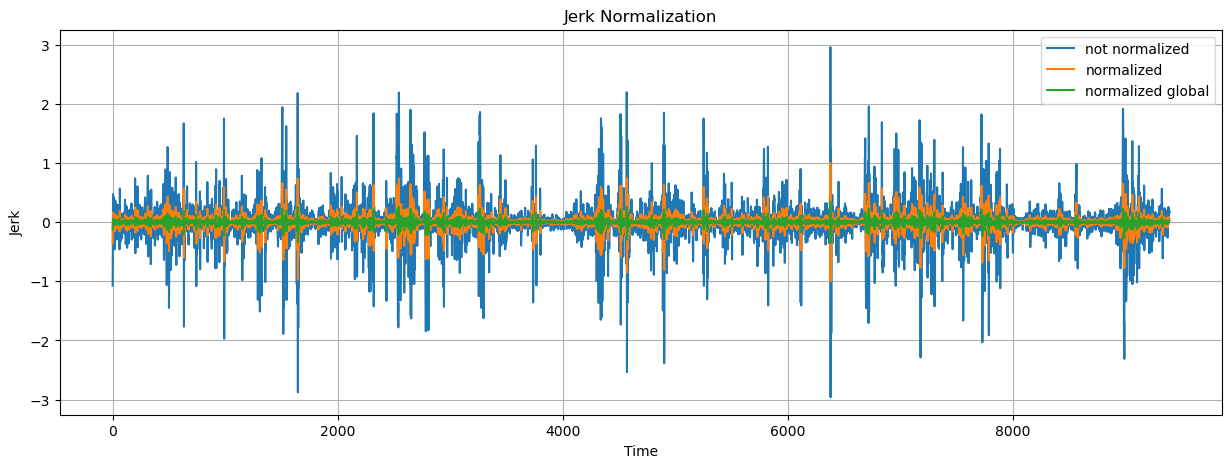

In [12]:
person = acc_dict[person_names[1]]

plt.figure(figsize=(15, 5))
plt.plot(person['time'], person['acc_vector_derivative'], label='not normalized')
plt.plot(person['time'], person['acc_vector_derivative_normalized'], label='normalized')
plt.plot(person['time'], person['acc_vector_derivative_normalized_global'], label='normalized global')
plt.xlabel('Time')
plt.ylabel('Jerk')
plt.title('Jerk Normalization')
plt.legend()
plt.grid(True)
plt.show()

# Jerk Representation
Calculate C as a constant that is multiplied to the integral of the jerk. Different apporaches:
* C = 1: to not influence integral. Keep in mind that ascending time has a big influence here and should be addressed accordingly
* C = 1 / ascending time: to normalize jerk over time. However, time is not represented by the feature anymore.
* C = time^5 / height^2: to make jerk dimensionless. Important to compare in fututre research and also to extract time to get an indicator for smoothnee. Changes the dimension but ascent time should again be kept in mind. Good paper: DOI = 10.3200/35-09-004-RC 

In [13]:
# Calculate the normalization constant C
for person_name in acc_dict:
    acc_dataset = acc_dict[person_name]

    timesteps = acc_dataset['time'] / 120
    start = timesteps[0]
    stop = timesteps[-1]
    time = stop - start
    C = (time ** 5) / (12 ** 2)
    acc_dataset['C'] = C

Compare C and measured time

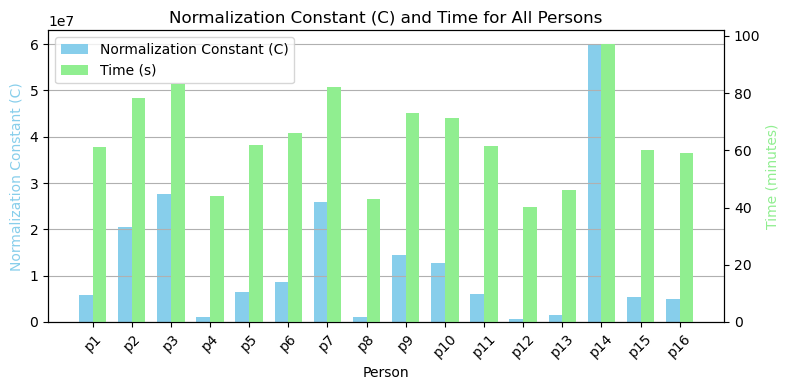

In [14]:
person_names = []
c_values = []
time_values = []

for person_name, acc_dataset in acc_dict.items():
    # Append person name, C value, and time value to lists
    person_names.append(person_name)
    c_values.append(acc_dataset['C'])
    time_values.append(acc_dataset['time'][-1] / 120)  # Convert to seconds

bar_width = 0.35

# Define the positions for the bars
r1 = np.arange(len(person_names))
r2 = [x + bar_width for x in r1]


fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot C values for all persons on primary axis
ax1.bar(r1, c_values, color='skyblue', width=bar_width, label='Normalization Constant (C)')
ax1.set_xlabel('Person')
ax1.set_ylabel('Normalization Constant (C)', color='skyblue')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y')

# Create secondary axis for time values
ax2 = ax1.twinx()
ax2.bar(r2, time_values, color='lightgreen', width=bar_width, label='Time (s)')
ax2.set_ylabel('Time (minutes)', color='lightgreen')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Adjust x-axis ticks
plt.xticks([r + bar_width / 2 for r in range(len(person_names))], person_names, rotation=45, ha='right')

plt.title('Normalization Constant (C) and Time for All Persons')
plt.tight_layout()
plt.show()

## Integrate Jerk

Different possibilites: <br>
* integrate absolute values
* integrate normalized squared values (according to Seifert - DOI: 10.1123/JAB.2014-0052)

In [15]:
jerk_values = {'acc_x': {}, 'acc_y': {}, 'acc_z': {}, 'acc_vector': {}, 'acc_xz': {}}

for person_name in acc_dict:
    acc_dataset = acc_dict[person_name]
    time = acc_dataset['time'] / 120
    C = acc_dataset['C'].values
    
    for axis in ['acc_x', 'acc_y', 'acc_z', 'acc_vector', 'acc_xz']:
        jerk = acc_dataset[f'{axis}_derivative_normalized{jerk_normalization}']
        
        # Integrate 
        integral_value = trapz(jerk ** 2, time)
        mean_jerk = C * integral_value

        jerk_values[axis][person_name] = mean_jerk
        acc_dataset[f'mean_jerk_{axis}'] = mean_jerk

In [16]:
print(C)

4968259.247820266


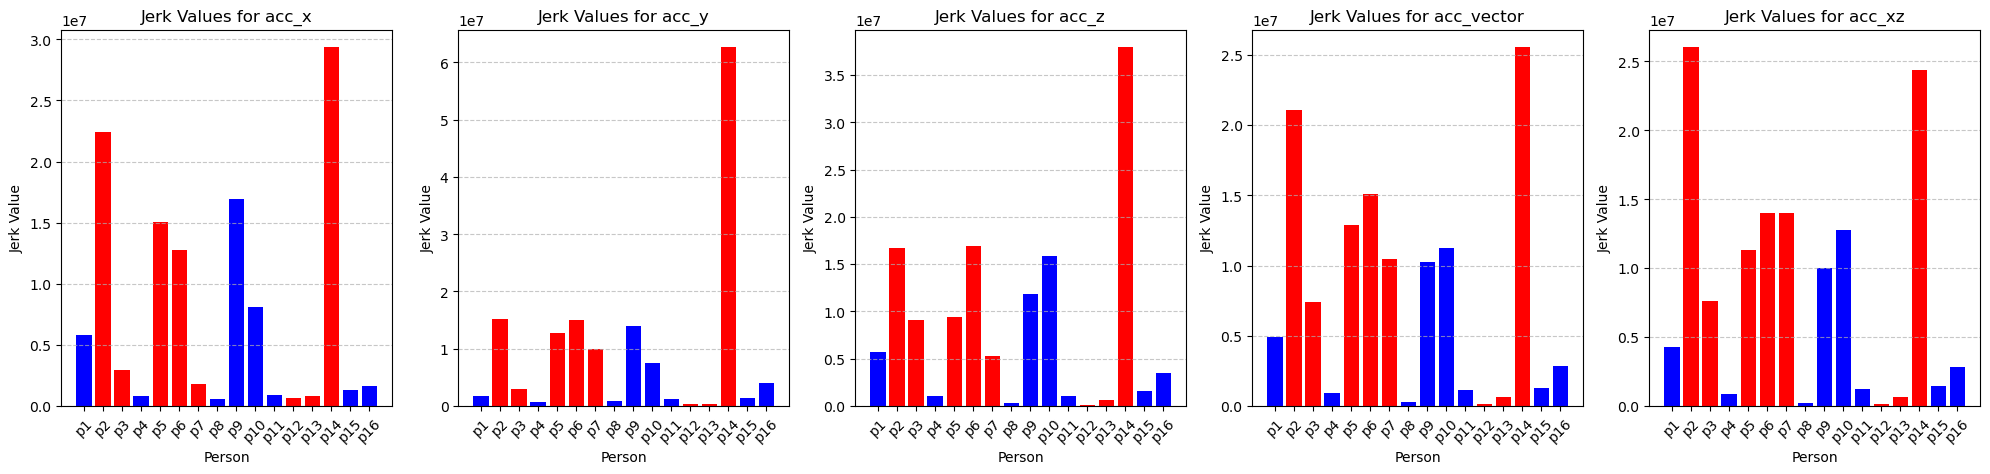

In [17]:
axes = ['acc_x', 'acc_y', 'acc_z', 'acc_vector', 'acc_xz']

fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, axis in enumerate(axes):
    person_names = list(jerk_values[axis].keys())
    values = list(jerk_values[axis].values())
    genders = [acc_dict[person_name]['gender'] for person_name in person_names]
    
    # Define colors based on gender
    colors = ['red' if gender == 'female' else 'blue' for gender in genders]
    
    # Plot the integrated values with colors
    axs[i].bar(person_names, values, color=colors)
    axs[i].set_xlabel('Person')
    axs[i].set_ylabel('Jerk Value')
    axs[i].set_title(f'Jerk Values for {axis}')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Mean Calculation representing each Group

In [18]:
jerk_values_women = {'acc_x': [], 'acc_y': [], 'acc_z': [], 'acc_vector': [], 'acc_xz': []}
jerk_values_men = {'acc_x': [], 'acc_y': [], 'acc_z': [], 'acc_vector': [], 'acc_xz': []}

for axis, values in jerk_values.items():
    person_names = list(values.keys())
    values = list(values.values())
    genders = [acc_dict[person_name]['gender'] for person_name in person_names]
    
    for person_name, jerk_value, gender in zip(person_names, values, genders):
        if gender == 'female':
            jerk_values_women[axis].append(jerk_value)
        elif gender == 'male':
            jerk_values_men[axis].append(jerk_value)

mean_jerk_values_women = {axis: np.mean(values) for axis, values in jerk_values_women.items()}
std_jerk_values_women = {axis: np.std(values) for axis, values in jerk_values_women.items()}
mean_jerk_values_men = {axis: np.mean(values) for axis, values in jerk_values_men.items()}
std_jerk_values_men = {axis: np.std(values) for axis, values in jerk_values_men.items()}


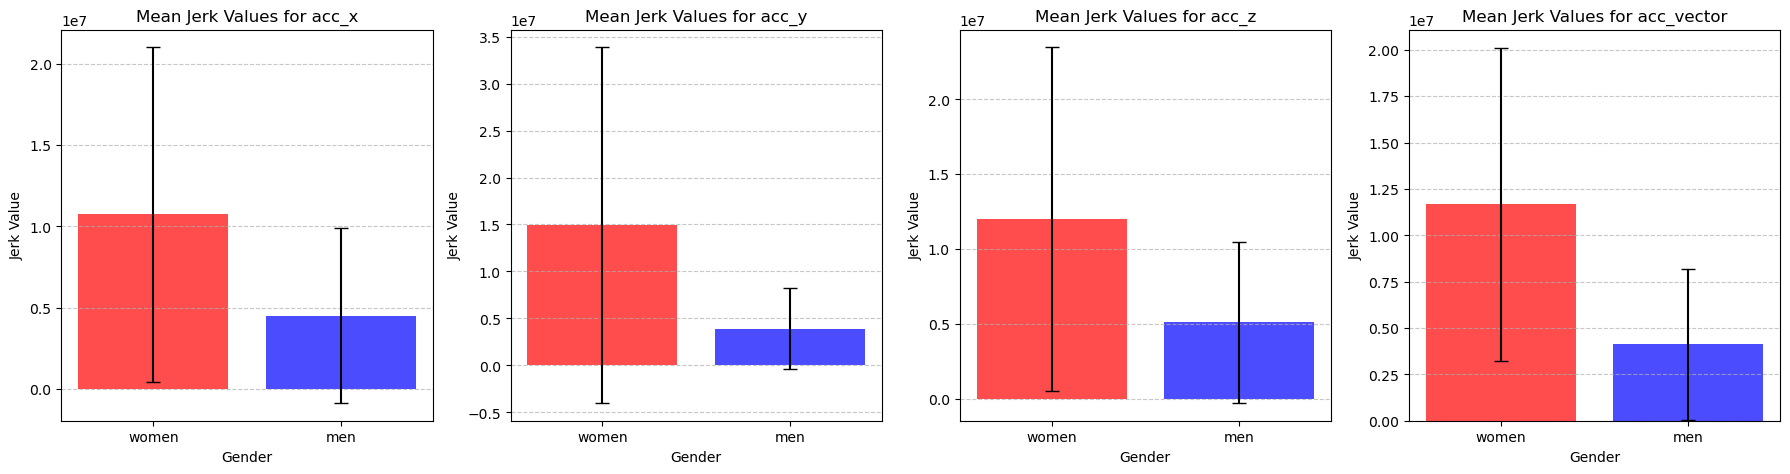

In [19]:
axes = ['acc_x', 'acc_y', 'acc_z', 'acc_vector']

fig, axs = plt.subplots(1, 4, figsize=(18, 5))

for i, axis in enumerate(axes):
    x_labels = ['women', 'men']
    x = range(len(x_labels))
    
    y_mean_values = [mean_jerk_values_women[axis], mean_jerk_values_men[axis]]
    y_std_values = [std_jerk_values_women[axis], std_jerk_values_men[axis]]
    
    colors = ['red', 'blue']
    axs[i].bar(x, y_mean_values, yerr=y_std_values, color=colors, alpha=0.7, capsize=5)
    
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(x_labels)
    axs[i].set_xlabel('Gender')
    axs[i].set_ylabel('Jerk Value')
    axs[i].set_title(f'Mean Jerk Values for {axis}')
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

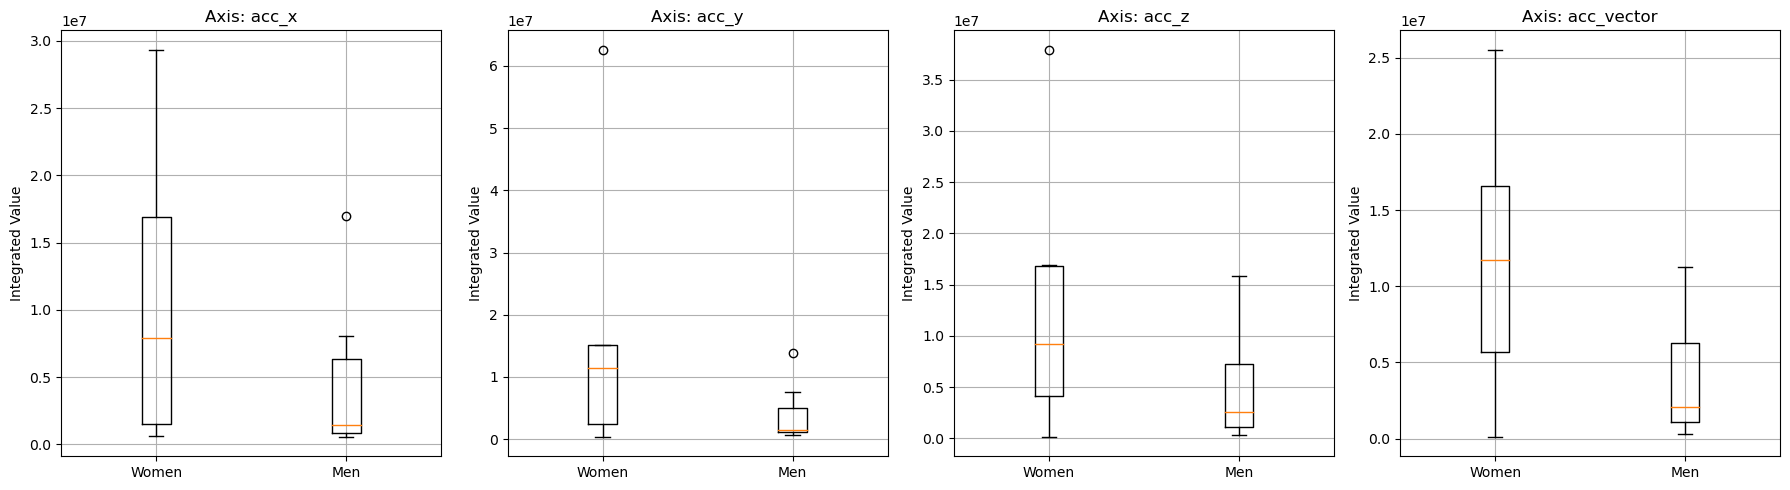

In [20]:
fig, axs = plt.subplots(1, 4, figsize=(18, 5))

for i, axis in enumerate(['acc_x', 'acc_y', 'acc_z', 'acc_vector']):
    person_names = list(jerk_values[axis].keys())
    values = list(jerk_values[axis].values())
    genders = [acc_dict[person_name]['gender'] for person_name in person_names]
    
    plot_jerk_values_women = [values[j] for j, gender in enumerate(genders) if gender == 'female']
    plot_jerk_values_men = [values[j] for j, gender in enumerate(genders) if gender == 'male']
    
    positions = [1, 2]
    axs[i].boxplot([plot_jerk_values_women, plot_jerk_values_men], positions=positions, labels=['Women', 'Men'])
    axs[i].set_ylabel('Integrated Value')
    axs[i].set_title(f'Axis: {axis}')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

# Export Data

In [21]:
%store acc_dict
%store jerk_values

df_list = []

# Iterate over each person's dataset
for person_name, dataset in acc_dict.items():
    person_data = {}
    person_data['person_name'] = person_name
    
    for var_name, var_value in dataset.items():
        # If the variable is a scalar (0-dimensional), directly add its value to the person's data
        if var_value.ndim == 0:
            if var_name == 'gender': 
                person_data[var_name] = 0 if var_value.item() == 'female' else 1
            else:
                person_data[var_name] = var_value.item()
    
    df_list.append(person_data)

# Convert the list of dictionaries to a DataFrame
final_df = pd.DataFrame(df_list)

# Save the DataFrame to a CSV file
final_df.to_csv('mean_jerk.csv', index=False, sep=';', decimal=',')

Stored 'acc_dict' (dict)
Stored 'jerk_values' (dict)
